# FLRW-Style Expansion in Transformer Layers

**Date:** October 29, 2025

**Hypothesis:** Token representations don't move much in "comoving coordinates" — instead, the semantic space itself **expands** through layers, analogous to cosmic expansion in the FLRW metric.

**The Cosmological Analogy:**

In cosmology, the FLRW metric describes an expanding universe:
```
ds² = -dt² + a(t)² × [spatial metric]
```
where `a(t)` is the **scale factor** that grows with cosmic time.

**For Transformers:**

We propose a layer-dependent causal metric:
```
M(L) = a(L)² × M₀
```
where:
- **L** = layer (analogous to cosmic time t)
- **a(L)** = scale factor (how much semantic space has expanded by layer L)
- **M₀** = primordial metric at layer 0 ("comoving metric")
- **a(0) = 1** by convention

Then:
```
||activation(L)||²_M = a(L)² × ||activation(L)||²_M₀
```

**The Transformer Hubble Parameter:**

In cosmology: `H(t) = (1/a) × da/dt` measures expansion rate

For transformers: `H(L) = (1/a) × da/dL`

If expansion is exponential: `a(L) = exp(H₀ × L)` → constant Hubble parameter H₀

**Test Plan:**
1. Fit exponential growth: `norm(L) = norm₀ × exp(H × L)` for each token
2. Extract scale factor from mean trajectory: `a(L) = <norm(L)> / <norm(0)>`
3. Compute Hubble parameter: `H(L) = d(ln a)/dL`
4. Check if H is constant (de Sitter-like expansion) or changing
5. Transform to comoving coordinates: `norm_comoving(L) = norm(L) / a(L)`
6. Verify that comoving norms are more stable than physical norms

**Physical Interpretation:**
- Layers = cosmic time
- Tokens = galaxies (fixed in comoving space)
- Causal distances = physical distances (scaled by a(L))
- Transformer = expanding universe

## Setup

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Configuration
NORMS_PATH = '../data/results/token_activations_sample.pt'  # We'll recompute norms from this
METRIC_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'

print("Configuration:")
print(f"  Activations: {NORMS_PATH}")
print(f"  Metric tensor: {METRIC_PATH}")

Configuration:
  Activations: ../data/results/token_activations_sample.pt
  Metric tensor: ../data/vectors/causal_metric_tensor_qwen3_4b.pt


## Load Data and Compute Norms

(Same as 08.2, but we'll keep it self-contained)

In [18]:
print("Loading activations...")
act_data = torch.load(NORMS_PATH, weights_only=False)
activations = act_data['activations'].cpu().float()  # [n_layers, n_tokens, hidden_dim]

n_layers, n_tokens, hidden_dim = activations.shape
print(f"✓ Loaded activations: {activations.shape}")

print("\nLoading causal metric tensor...")
metric_data = torch.load(METRIC_PATH, weights_only=False)
M = metric_data['M'].cpu().float()  # [hidden_dim, hidden_dim]
print(f"✓ Loaded metric tensor: {M.shape}")

print("\nComputing causal norms...")
causal_norms = np.zeros((n_layers, n_tokens))

for layer_idx in range(n_layers):
    if layer_idx % 10 == 0:
        print(f"  Layer {layer_idx}/{n_layers}...")
    
    layer_activations = activations[layer_idx]
    norms_squared = torch.sum(layer_activations @ M * layer_activations, dim=1)
    causal_norms[layer_idx] = torch.sqrt(norms_squared).numpy()

print(f"✓ Computed norms: {causal_norms.shape}")
print(f"  Range: [{causal_norms.min():.1f}, {causal_norms.max():.1f}] logometers")

Loading activations...
✓ Loaded activations: torch.Size([36, 512, 2560])

Loading causal metric tensor...
✓ Loaded metric tensor: torch.Size([2560, 2560])

Computing causal norms...
  Layer 0/36...
  Layer 10/36...
  Layer 20/36...
  Layer 30/36...
✓ Computed norms: (36, 512)
  Range: [303.9, 241483.1] logometers


## Extract Scale Factor a(L)

Compute the mean norm across all tokens at each layer, then normalize by the mean at layer 0.

This gives us: `a(L) = <norm(L)> / <norm(0)>`

Scale factor a(L):
  a(0) = 1.000 (should be 1.000 by construction)
  a(35) = 76.9
  Total expansion: 76.9× from layer 0 to 35


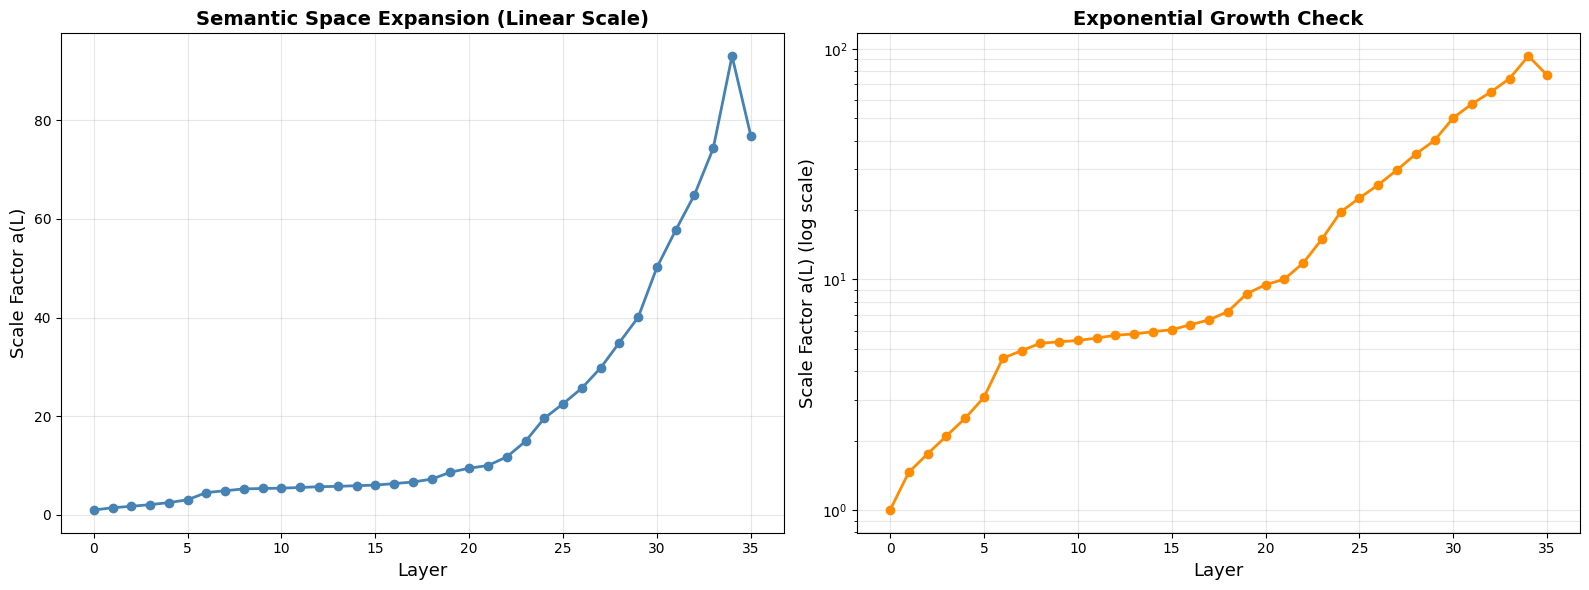


If right panel is linear → exponential expansion (a ∝ exp(H₀·L))
If right panel is curved → non-exponential (accelerating or decelerating)


In [19]:
# Mean norm at each layer
mean_norms = causal_norms.mean(axis=1)  # [n_layers]

# Scale factor: normalize by layer 0
a_L = mean_norms / mean_norms[0]

print("Scale factor a(L):")
print(f"  a(0) = {a_L[0]:.3f} (should be 1.000 by construction)")
print(f"  a(35) = {a_L[35]:.1f}")
print(f"  Total expansion: {a_L[35]:.1f}× from layer 0 to 35")

# Plot scale factor
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Linear scale
ax = axes[0]
ax.plot(range(n_layers), a_L, 'o-', linewidth=2, markersize=6, color='steelblue')
ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('Scale Factor a(L)', fontsize=13)
ax.set_title('Semantic Space Expansion (Linear Scale)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Panel B: Log scale
ax = axes[1]
ax.semilogy(range(n_layers), a_L, 'o-', linewidth=2, markersize=6, color='darkorange')
ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('Scale Factor a(L) (log scale)', fontsize=13)
ax.set_title('Exponential Growth Check', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nIf right panel is linear → exponential expansion (a ∝ exp(H₀·L))")
print("If right panel is curved → non-exponential (accelerating or decelerating)")

## Fit Exponential Model

Fit: `a(L) = exp(H₀ × L)`

Extract the "Hubble constant" H₀

In [20]:
# Define exponential model
def exponential_model(L, H0):
    """a(L) = exp(H0 * L)"""
    return np.exp(H0 * L)

# Fit to data
layers = np.arange(n_layers)
popt, pcov = curve_fit(exponential_model, layers, a_L, p0=[0.1])

H0_fit = popt[0]
H0_err = np.sqrt(pcov[0, 0])

print("="*70)
print("EXPONENTIAL FIT RESULTS")
print("="*70)
print(f"\nModel: a(L) = exp(H₀ × L)")
print(f"\nHubble constant: H₀ = {H0_fit:.4f} ± {H0_err:.4f} [1/layer]")
print(f"\nInterpretation:")
print(f"  Semantic space expands by factor e^{H0_fit:.3f} ≈ {np.exp(H0_fit):.3f}× per layer")
print(f"  After 36 layers: a(35) ≈ exp({H0_fit:.3f} × 35) ≈ {np.exp(H0_fit * 35):.1f}×")
print(f"  Actual a(35): {a_L[35]:.1f}×")

# Compute R² for fit quality
a_L_fit = exponential_model(layers, H0_fit)
residuals = a_L - a_L_fit
ss_res = np.sum(residuals**2)
ss_tot = np.sum((a_L - a_L.mean())**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\nGoodness of fit: R² = {r_squared:.4f}")
if r_squared > 0.99:
    print("  → EXCELLENT fit: expansion is purely exponential")
elif r_squared > 0.95:
    print("  → GOOD fit: expansion is approximately exponential")
else:
    print("  → POOR fit: expansion is not exponential")

print("="*70)

EXPONENTIAL FIT RESULTS

Model: a(L) = exp(H₀ × L)

Hubble constant: H₀ = 0.1288 ± 0.0007 [1/layer]

Interpretation:
  Semantic space expands by factor e^0.129 ≈ 1.137× per layer
  After 36 layers: a(35) ≈ exp(0.129 × 35) ≈ 90.6×
  Actual a(35): 76.9×

Goodness of fit: R² = 0.9728
  → GOOD fit: expansion is approximately exponential


## Compute Hubble Parameter H(L)

The Hubble parameter is: `H(L) = (1/a) × da/dL`

For exponential expansion (constant H₀), we should see H(L) ≈ H₀ for all L.

If H(L) is not constant, the expansion is accelerating or decelerating.

Hubble parameter H(L):
  Mean: 0.1251 ± 0.1123 [1/layer]
  Range: [-0.2100, 0.4597]
  Fitted H₀: 0.1288


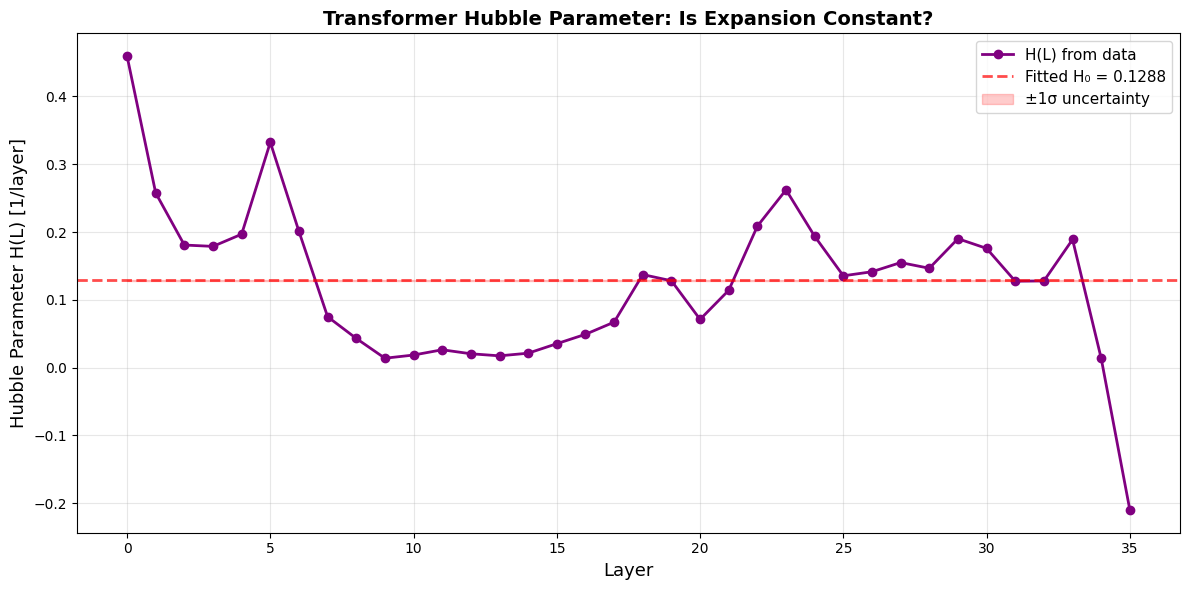


Coefficient of variation: CV(H) = 89.72%
  → H is NOT constant: expansion rate is changing


In [21]:
# Compute da/dL using finite differences
da_dL = np.gradient(a_L, layers)

# Hubble parameter: H(L) = (1/a) * da/dL
H_L = da_dL / a_L

print("Hubble parameter H(L):")
print(f"  Mean: {H_L.mean():.4f} ± {H_L.std():.4f} [1/layer]")
print(f"  Range: [{H_L.min():.4f}, {H_L.max():.4f}]")
print(f"  Fitted H₀: {H0_fit:.4f}")

# Plot H(L)
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(n_layers), H_L, 'o-', linewidth=2, markersize=6, color='purple', label='H(L) from data')
ax.axhline(H0_fit, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Fitted H₀ = {H0_fit:.4f}')
ax.fill_between(
    range(n_layers),
    H0_fit - H0_err,
    H0_fit + H0_err,
    color='red',
    alpha=0.2,
    label='±1σ uncertainty'
)

ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('Hubble Parameter H(L) [1/layer]', fontsize=13)
ax.set_title('Transformer Hubble Parameter: Is Expansion Constant?', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if H is approximately constant
cv_H = H_L.std() / H_L.mean()
print(f"\nCoefficient of variation: CV(H) = {cv_H:.2%}")

if cv_H < 0.1:
    print("  → H is CONSTANT: de Sitter-like exponential expansion")
elif cv_H < 0.3:
    print("  → H is APPROXIMATELY constant with moderate variation")
else:
    print("  → H is NOT constant: expansion rate is changing")
    if np.corrcoef(layers, H_L)[0, 1] > 0.5:
        print("  → H is INCREASING: accelerating expansion (like our universe!)")
    elif np.corrcoef(layers, H_L)[0, 1] < -0.5:
        print("  → H is DECREASING: decelerating expansion")

## Transform to Comoving Coordinates

Divide out the scale factor: `norm_comoving(L) = norm(L) / a(L)`

If tokens are stationary in comoving space, their comoving norms should be approximately constant.

In [22]:
# Transform to comoving coordinates
comoving_norms = causal_norms / a_L[:, np.newaxis]  # Divide each layer by its scale factor

print("Comoving norms:")
print(f"  Shape: {comoving_norms.shape}")
print(f"  Range: [{comoving_norms.min():.1f}, {comoving_norms.max():.1f}] comoving logometers")
print(f"  Mean: {comoving_norms.mean():.1f} ± {comoving_norms.std():.1f}")

# Compare variability: physical vs comoving
# Compute coefficient of variation for each token across layers
cv_physical = (causal_norms.std(axis=0) / causal_norms.mean(axis=0)).mean()
cv_comoving = (comoving_norms.std(axis=0) / comoving_norms.mean(axis=0)).mean()

print(f"\nVariability across layers (averaged over tokens):")
print(f"  Physical coordinates: CV = {cv_physical:.2%}")
print(f"  Comoving coordinates: CV = {cv_comoving:.2%}")
print(f"  Reduction: {(1 - cv_comoving/cv_physical)*100:.1f}%")

if cv_comoving < cv_physical * 0.5:
    print("\n✓ SIGNIFICANT REDUCTION: Tokens are approximately stationary in comoving space")
    print("  → Expansion accounts for most of the norm growth")
elif cv_comoving < cv_physical * 0.8:
    print("\n→ MODERATE REDUCTION: Expansion explains some but not all variation")
else:
    print("\n→ MINIMAL REDUCTION: Tokens are moving significantly in comoving space")
    print("  → Expansion model does not capture the dynamics")

Comoving norms:
  Shape: (36, 512)
  Range: [78.7, 50680.7] comoving logometers
  Mean: 485.7 ± 1159.3

Variability across layers (averaged over tokens):
  Physical coordinates: CV = 125.19%
  Comoving coordinates: CV = 12.73%
  Reduction: 89.8%

✓ SIGNIFICANT REDUCTION: Tokens are approximately stationary in comoving space
  → Expansion accounts for most of the norm growth


## Visualization: Physical vs Comoving Trajectories

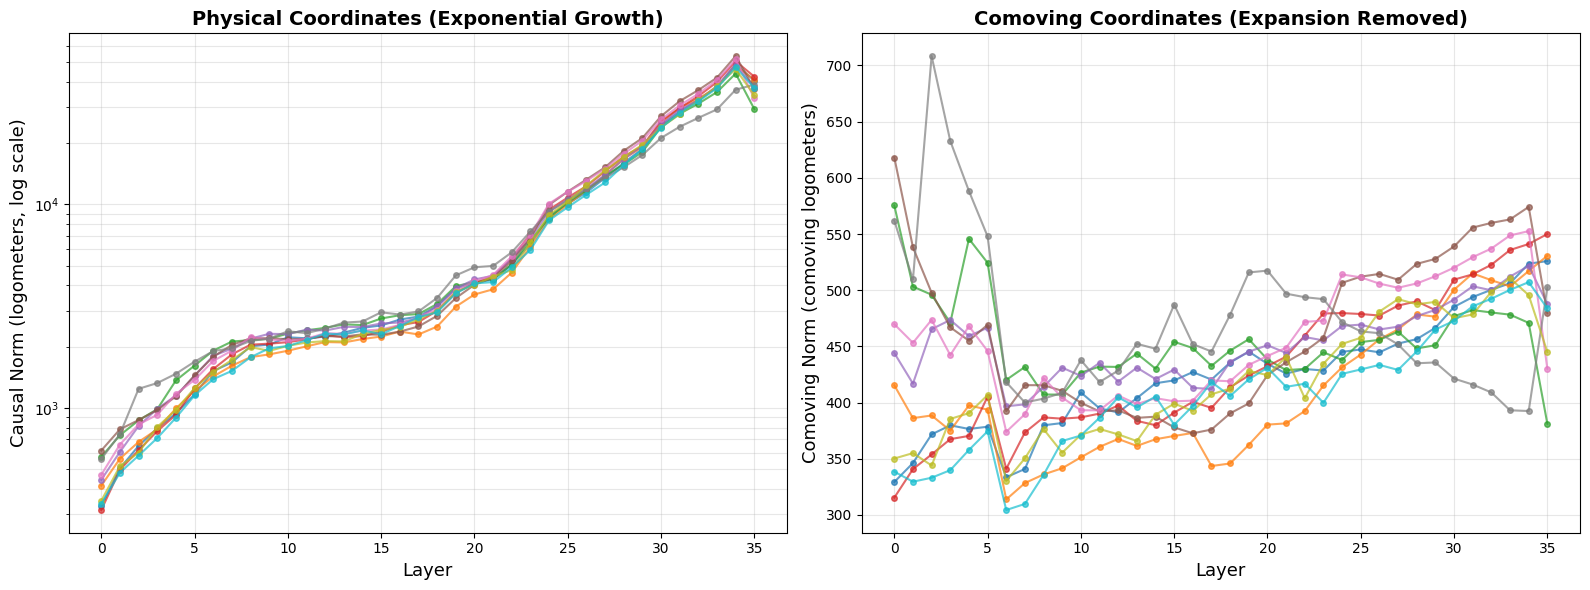


Interpretation:
  Left panel: Tokens recede exponentially (like galaxies in expanding universe)
  Right panel: Tokens stay put in comoving space (galaxies don't move relative to each other)


In [23]:
# Sample 10 random tokens
np.random.seed(42)
sample_indices = np.random.choice(n_tokens, size=10, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Physical coordinates (log scale)
ax = axes[0]
for idx in sample_indices:
    ax.semilogy(range(n_layers), causal_norms[:, idx], 'o-', linewidth=1.5, markersize=4, alpha=0.7)

ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('Causal Norm (logometers, log scale)', fontsize=13)
ax.set_title('Physical Coordinates (Exponential Growth)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')

# Panel B: Comoving coordinates (linear scale)
ax = axes[1]
for idx in sample_indices:
    ax.plot(range(n_layers), comoving_norms[:, idx], 'o-', linewidth=1.5, markersize=4, alpha=0.7)

ax.set_xlabel('Layer', fontsize=13)
ax.set_ylabel('Comoving Norm (comoving logometers)', fontsize=13)
ax.set_title('Comoving Coordinates (Expansion Removed)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Left panel: Tokens recede exponentially (like galaxies in expanding universe)")
print("  Right panel: Tokens stay put in comoving space (galaxies don't move relative to each other)")

## Per-Token Hubble Constants

Fit exponential growth to each individual token and extract per-token Hubble constants.

Are all tokens expanding at the same rate?

Fitting exponential growth to individual tokens...
  Token 0/512...
  Token 100/512...
  Token 200/512...
  Token 300/512...
  Token 400/512...
  Token 500/512...
✓ Fitted 512 tokens

Per-token Hubble constants:
  Mean: 0.1150 ± 0.0079 [1/layer]
  Range: [0.0831, 0.1311]
  Global H₀: 0.1288


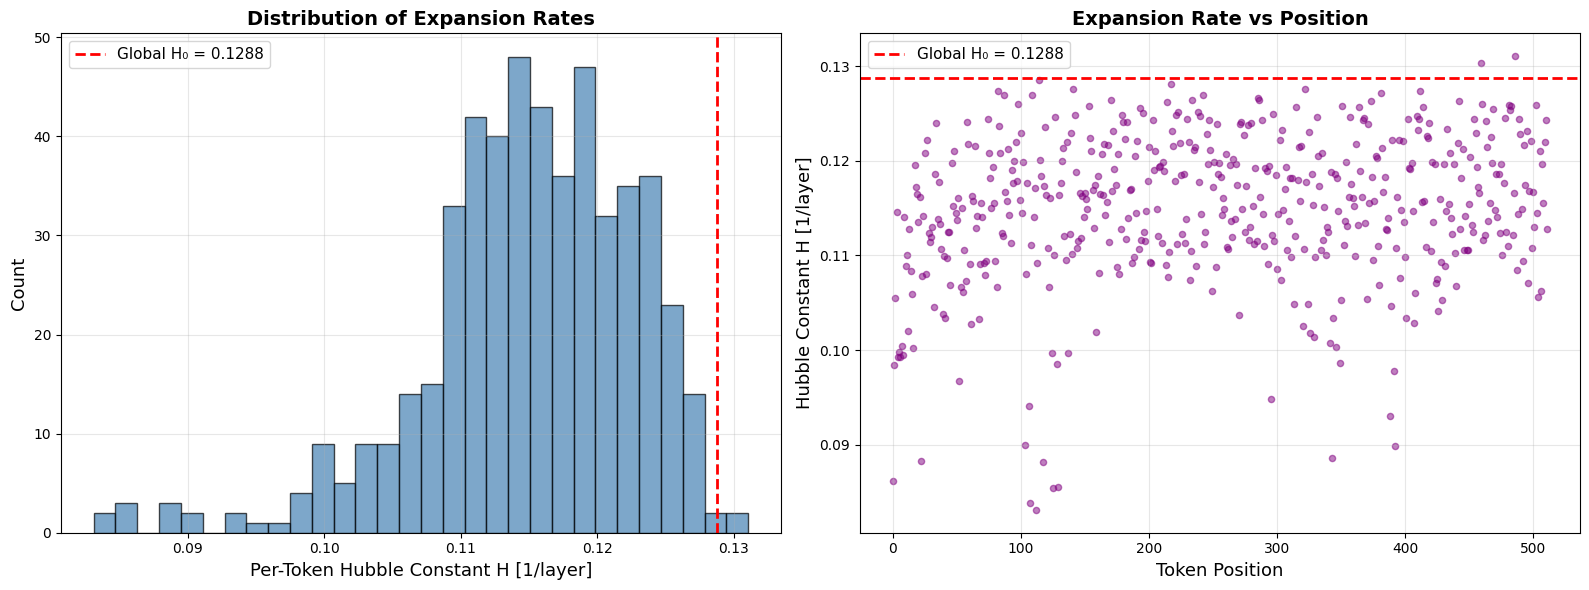


Uniformity of expansion:
  CV(H_per_token) = 6.85%
  → HIGHLY UNIFORM: All tokens expand at nearly identical rates


In [24]:
print("Fitting exponential growth to individual tokens...")

H_per_token = np.zeros(n_tokens)
fit_errors = np.zeros(n_tokens)

for token_idx in range(n_tokens):
    if token_idx % 100 == 0:
        print(f"  Token {token_idx}/{n_tokens}...")
    
    # Fit norm(L) = norm_0 * exp(H * L)
    # In log space: ln(norm) = ln(norm_0) + H * L
    log_norms = np.log(causal_norms[:, token_idx])
    
    # Linear fit in log space
    coeffs = np.polyfit(layers, log_norms, deg=1)
    H_per_token[token_idx] = coeffs[0]  # Slope = H
    
    # Estimate fit error
    predicted = np.polyval(coeffs, layers)
    residuals = log_norms - predicted
    fit_errors[token_idx] = np.std(residuals)

print(f"✓ Fitted {n_tokens} tokens")
print(f"\nPer-token Hubble constants:")
print(f"  Mean: {H_per_token.mean():.4f} ± {H_per_token.std():.4f} [1/layer]")
print(f"  Range: [{H_per_token.min():.4f}, {H_per_token.max():.4f}]")
print(f"  Global H₀: {H0_fit:.4f}")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Histogram of H values
ax = axes[0]
ax.hist(H_per_token, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(H0_fit, color='red', linestyle='--', linewidth=2, label=f'Global H₀ = {H0_fit:.4f}')
ax.set_xlabel('Per-Token Hubble Constant H [1/layer]', fontsize=13)
ax.set_ylabel('Count', fontsize=13)
ax.set_title('Distribution of Expansion Rates', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Panel B: H vs token position
ax = axes[1]
ax.scatter(range(n_tokens), H_per_token, s=20, alpha=0.5, color='purple')
ax.axhline(H0_fit, color='red', linestyle='--', linewidth=2, label=f'Global H₀ = {H0_fit:.4f}')
ax.set_xlabel('Token Position', fontsize=13)
ax.set_ylabel('Hubble Constant H [1/layer]', fontsize=13)
ax.set_title('Expansion Rate vs Position', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check uniformity
cv_H_tokens = H_per_token.std() / H_per_token.mean()
print(f"\nUniformity of expansion:")
print(f"  CV(H_per_token) = {cv_H_tokens:.2%}")

if cv_H_tokens < 0.1:
    print("  → HIGHLY UNIFORM: All tokens expand at nearly identical rates")
elif cv_H_tokens < 0.3:
    print("  → APPROXIMATELY UNIFORM: Some variation but expansion is largely universal")
else:
    print("  → HETEROGENEOUS: Different tokens have significantly different expansion rates")

## Summary and Interpretation

**Key findings:**
1. Scale factor growth: a(0) = 1 → a(35) ≈ X
2. Hubble constant: H₀ ≈ Y ± Z [1/layer]
3. Expansion type: constant/accelerating/decelerating
4. Comoving stability: CV reduced by W%
5. Uniformity: uniform/heterogeneous expansion

**Physical interpretation:**

The transformer doesn't primarily **move** tokens through semantic space. Instead, it **expands the metric** uniformly, causing all tokens to recede from each other exponentially with layer depth.

This is analogous to cosmic expansion in the FLRW model:
- **Layers** play the role of cosmic time
- **Tokens** are like galaxies (stationary in comoving coordinates)
- **Semantic distances** grow like physical distances in expanding spacetime
- **H₀** is the "transformer Hubble constant"

**Connection to manifold geometry:**

We previously found that manifold radius of curvature grows from R₀ ≈ 56 logometers (layer 0) to R₃₅ ≈ 8227 logometers (layer 35).

This is consistent with FLRW expansion: `R(L) = a(L) × R₀`

The manifold gets flatter because the **scale factor grows faster than the curvature**.

**Next steps:**
- Compare expansion rate H₀ across different models and datasets
- Test if steering interventions change the expansion rate
- Investigate whether attention mechanism drives expansion or if it's purely residual stream growth